# Analyse time and memory consumption of AN2VEC

In [1]:
import re
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

plt.style.use('bmh')
sb.set_context('paper', font_scale=1.5)

In [2]:
datapath = '../../data/behaviour/memory-time'
basename = ('git=0335ce8eed-'
            'l=50,100,200,500,1000,2000,5000,10000-k=10-'
            'diml1enc=100-diml1dec=100-'
            'dimxiadj=16-dimxifeat=16-overlap=0,8,16-'
            'bias=false-sharedl1=false-decadjdeep=true,false-'
            'nepochs=200')
basepath = datapath + '/' + basename

## Compute time

Read the recorded job data from the csv file saved by GNU Parallel, and process its contents to extract:
- `JobRunime` / `Full script time`: the time it takes for the an2vec script to run *in full*
- `ComputeTime` / `Training time`: the time it takes for the actual training to run (so excluding data loading, pre-compilation, etc.)

In [3]:
time = pd.read_csv(basepath + '.csv')

time_pattern = re.compile('Time: ([0-9]+:[0-9]+:[0-9]+)')
def parse_time(s):
    match = re.search(time_pattern, s)
    if match is None:
        assert "OutOfMemory" in s
        return np.nan
    parts = match.groups()[0].split(':')
    return int(parts[-1]) + 60 * int(parts[-2]) + 3600 * int(parts[-3])

time['ComputeTime'] = time.Stderr.map(parse_time)
time = time[['Seq', 'JobRuntime', 'decadjdeep', 'l', 'k', 'dimxi', 'ComputeTime']]

Make a helper to format our log axis ticks

In [4]:
def format_logtick(n):
    exponent = int(np.log10(n))
    factor = int(n / 10**exponent)
    assert factor == n / 10**exponent
    if exponent == 0:
        return str(factor)
    times = r'{} \times '.format(factor) if factor > 1 else ''
    return r'$\mathregular{' + times + '10^{}'.format(exponent) + '}$'

Plot training time and full script run time

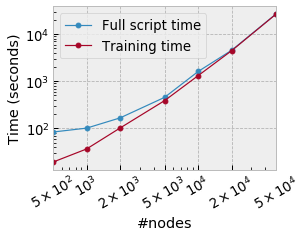

In [5]:
compute_job_times = time[time.decadjdeep == True]\
    .groupby('l')['JobRuntime', 'ComputeTime']\
    .mean()\
    .dropna()\
    .rename(columns={'ComputeTime': 'Training time', 'JobRuntime': 'Full script time'})
# Convert index from `l` to `#nodes`
k = time.k.unique().item()

compute_job_times.index = compute_job_times.index * k
compute_job_times.index.names = ['#nodes']

ax = compute_job_times.plot(marker='o', logx=True, logy=True, figsize=(4, 3))
nticks = np.array(list(filter(np.isfinite, time.dropna().l.unique()))) * k
yticks = np.array([1e2, 1e3, 1e4])
ax.set(xticks=nticks,
       xticklabels=list(map(format_logtick, nticks)),
       xlabel='#nodes',
       yticks=yticks,
       yticklabels=list(map(format_logtick, yticks)),
       ylabel='Time (seconds)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

ax.figure.savefig(basepath + '-time.pdf', bbox_inches='tight')

## Memory consumption

### Preprocessing

Import and parse the data logged by `top`

In [6]:
def parse_with_units(s):
    if s[-1] == 't':
        return float(s[:-1]) * 1e9
    if s[-1] == 'g':
        return float(s[:-1]) * 1e6
    if s[-1] == 'm':
        return float(s[:-1]) * 1e3
    else:
        return float(s)

memory = defaultdict(list)
whitespace = re.compile(' +')
with open(basepath + '.memory.log', 'r') as f:
    for line in f:
        parts = whitespace.split(line.strip())
        try:
            memory['virtual'].append(parse_with_units(parts[4]))
            memory['resident'].append(parse_with_units(parts[5]))
            memory['shared'].append(parse_with_units(parts[6]))
            memory['%cpu'].append(float(parts[8]))
            memory['%mem'].append(float(parts[9]))
        except IndexError:
            break

memory = pd.DataFrame(memory)
memory_cols = ['virtual', 'resident', 'shared']
percentage_cols = ['%cpu', '%mem']

Have a look at the memory and cpu usages

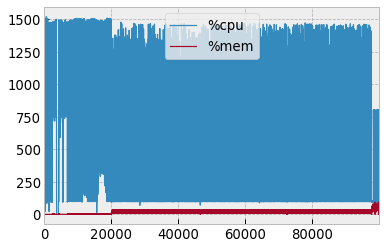

In [7]:
memory.iloc[:100000].plot(y=percentage_cols)

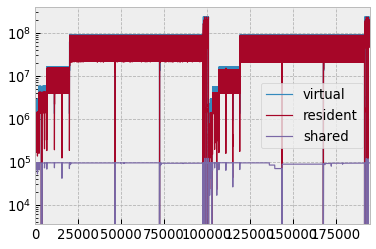

In [8]:
memory.plot(y=memory_cols, logy=True)

Define the ranges of line numbers (in the `top` lop) that correspond to each network size. This is done manually by zooming into areas in the plot right abev (plot of memory usage over time).

In [9]:
memory['l'] = np.nan
memory.l[0:225] = 50
memory.l[250:525] = 100
memory.l[550:1000] = 200
memory.l[1100:2300] = 500
memory.l[2500:6500] = 1000
memory.l[7000:20000] = 2000
memory.l[20000:90000] = 5000

### Plot

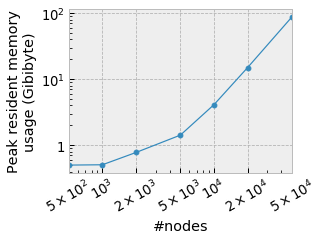

In [10]:
memory_per_nodes = memory.groupby('l').max()
memory_per_nodes.index = memory_per_nodes.index * k
memory_per_nodes.index.names = ['#nodes']

ax = memory_per_nodes.plot(marker='o', y='resident', logy=True, logx=True, legend=False, figsize=(4, 3))

yticks = np.array([1e6, 1e7, 1e8])
ax.set(xticks=nticks,
       xticklabels=list(map(format_logtick, nticks)),
       xlabel='#nodes',
       yticks=yticks,
       yticklabels=list(map(format_logtick, yticks * 1e-6)),
       ylabel='Peak resident memory\nusage (Gibibyte)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

ax.figure.savefig(basepath + '-memory.pdf', bbox_inches='tight')